<h2 align="center">Predict Employee Churn with Decision Trees and Random Forests</h2>

### Import Libraries
---

In [1]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

### Exploratory Data Analysis
---

In [3]:
hr = pd.read_csv('employee_data.csv')
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
!pip install visions==0.7.4
!pip install pydantic<2.0


zsh:1: no such file or directory: 2.0


In [5]:
pip install ydata-profiling

  Using cached visions-0.7.6-py3-none-any.whl.metadata (11 kB)
Using cached visions-0.7.6-py3-none-any.whl (104 kB)
  Attempting uninstall: visions
    Found existing installation: visions 0.7.4
    Uninstalling visions-0.7.4:
      Successfully uninstalled visions-0.7.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires visions[type_image_path]==0.7.4, but you have visions 0.7.6 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [6]:
from ydata_profiling import ProfileReport

In [7]:
hr.profile_report(title = "Data Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

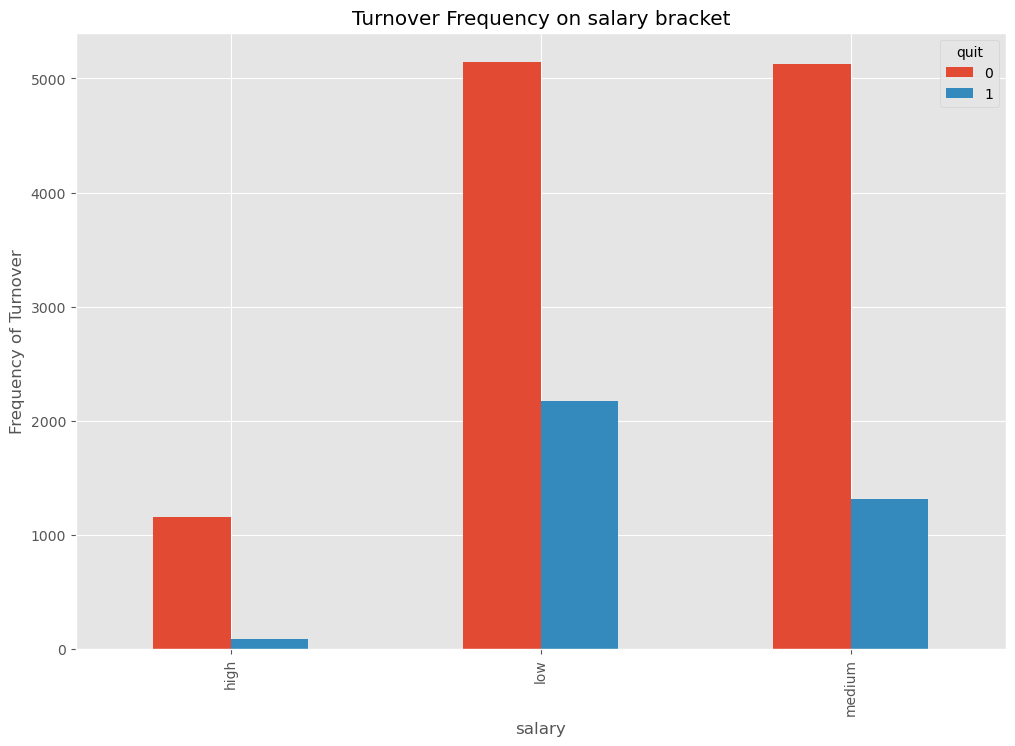

In [8]:
pd.crosstab(hr.salary,hr.quit).plot(kind="bar")
plt.title("Turnover Frequency on salary bracket")
plt.xlabel('salary')
plt.ylabel('Frequency of Turnover')
plt.show()

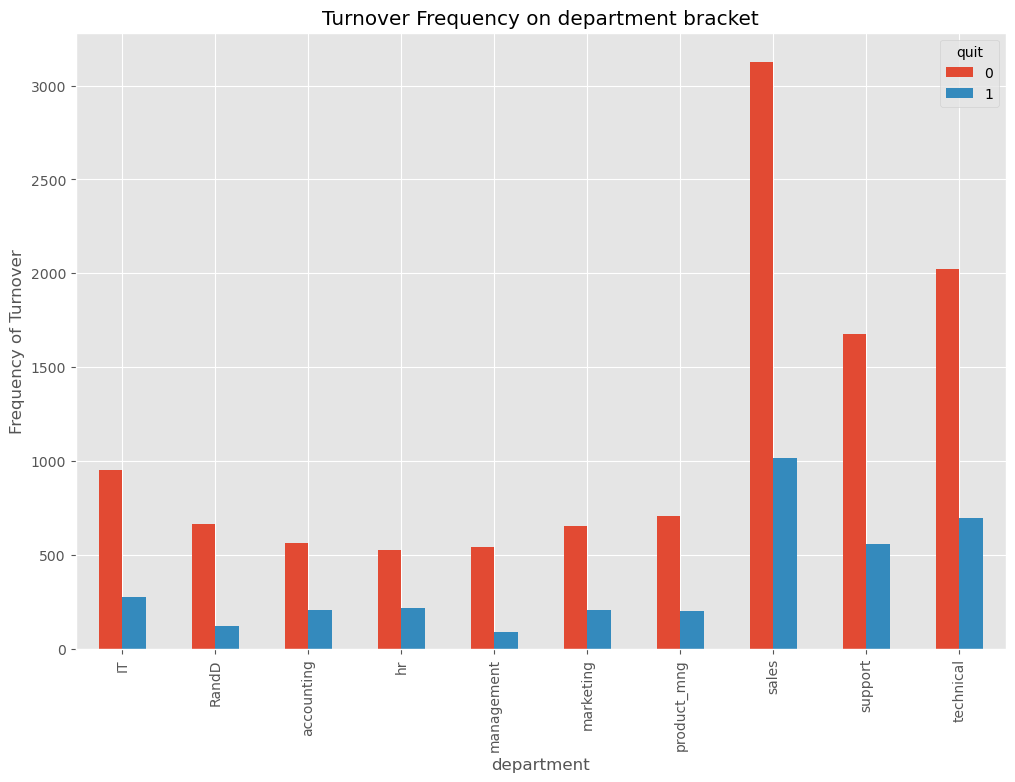

In [9]:
pd.crosstab(hr.department,hr.quit).plot(kind="bar")
plt.title("Turnover Frequency on department bracket")
plt.xlabel('department')
plt.ylabel('Frequency of Turnover')
plt.show()

### Encode Categorical Features
---

In [10]:
cat_vars = ['department','salary']
for var in cat_vars:
    cat_list = pd.get_dummies(hr[var],prefix = var)
    hr = hr.join(cat_list)

In [11]:
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,sales,low,...,False,False,False,False,True,False,False,False,True,False
1,0.80,0.86,5,262,6,0,1,0,sales,medium,...,False,False,False,False,True,False,False,False,False,True
2,0.11,0.88,7,272,4,0,1,0,sales,medium,...,False,False,False,False,True,False,False,False,False,True
3,0.72,0.87,5,223,5,0,1,0,sales,low,...,False,False,False,False,True,False,False,False,True,False
4,0.37,0.52,2,159,3,0,1,0,sales,low,...,False,False,False,False,True,False,False,False,True,False


In [12]:
hr.drop(columns = ['department','salary'],axis = 1, inplace = True)

### Visualize Class Imbalance
---

In [13]:
!pip install yellowbrick

In [14]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

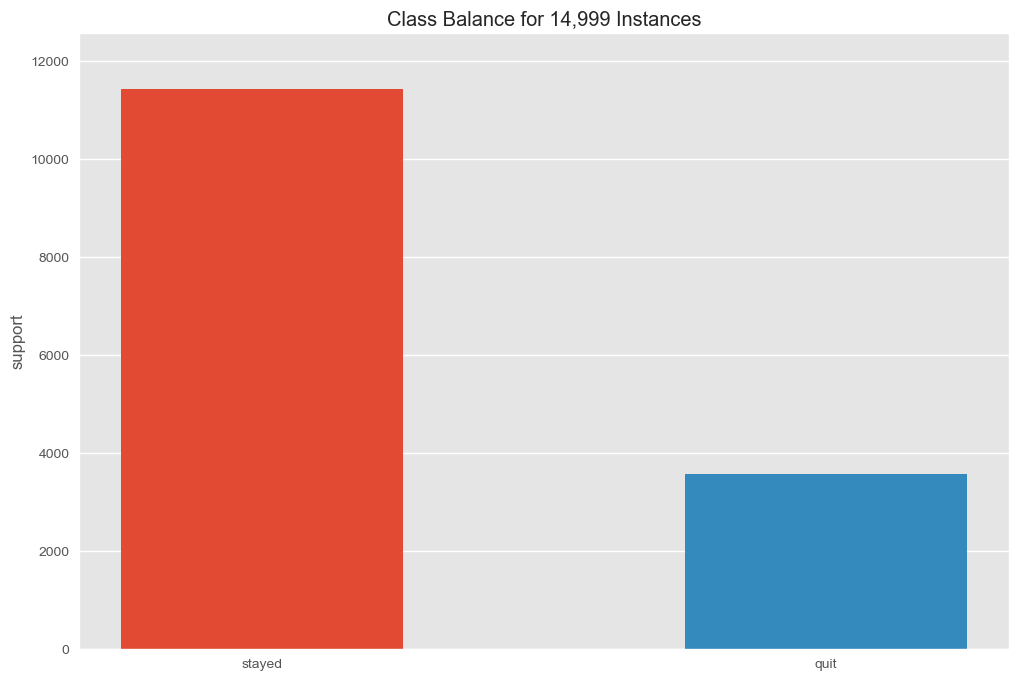

<Axes: title={'center': 'Class Balance for 14,999 Instances'}, ylabel='support'>

In [15]:
visualizer = ClassBalance(labels = ['stayed','quit']).fit(hr.quit)
visualizer.show()

### Create Training and Test Sets
---

In [16]:
X = hr.loc[:,hr.columns != 'quit']
y = hr.quit

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0,test_size = 0.2,stratify = y)

### Build an Interactive Decision Tree Classifier
---

Supervised learning: 
- The inputs are random variables $X = X_1, ..., X_p$;
- The output is a random variable $Y.$

- Data is a finite set $$\mathbb{L}=\{(x_i,y_i)|i=0, ..., N-1\}$$
where $x_i \in X = X_1 \times ... \times X_p$ and $y_i \in y$ are randomly drawn from $P_{X,Y}.$

E.g., $(x_i,y_i)=((\text{salary = low, department = sales, ...}),\text{quit = 1})$

- The goal is to find a model $\varphi_\mathbb{L}: X \mapsto y$ minimizing $$\text{Err}(\varphi_\mathbb{L}) = \mathbb{E}_{X,Y}\{L(Y, \varphi_\mathbb{L}(X))\}.$$

About:
 
 - Decision trees are non-parametric models which can model arbitrarily complex relations between inputs and outputs, without any a priori assumption
 
- Decision trees handle numeric and categorical variables

- They implement feature selection, making them robust to noisy features (to an extent)

- Robust to outliers or errors in labels

- Easily interpretable by even non-ML practioners.

#### Decision trees: partitioning the feature space:

![partition](assets/images/partition-feature-space.png)

- Decision trees generally have low bias but have high variance.
- We will solve the high variance problem in Task 8.

In [18]:
!pip install graphviz


In [19]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [20]:
@interact
def plot_tree(crit=['gini','entropy'],
              split=['best','random'],
              depth=IntSlider(min=1,max=30,value=2, continuous_update=False),
              min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=2, continuous_update=False)):

    estimator = DecisionTreeClassifier(random_state = 0,
                                       criterion=crit,
                                       splitter=split,
                                       max_depth=depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf= min_leaf)
    estimator.fit(X_train,y_train)
    print('Decision Tree Training Accuracy: {:.3f}'.format(accuracy_score(y_train,estimator.predict(X_train))))
    print('Decision Tree Test Accuracy: {:.3f}'.format(accuracy_score(y_test,estimator.predict(X_test))))
    graph = Source(tree.export_graphviz(estimator,out_file = None,
                                        feature_names = X_train.columns,
                                        class_names = ['stayed','quit'],
                                        filled = True))
    display(Image(data= graph.pipe(format = 'png')))
    return estimator
    

    

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Build an Interactive Random Forest Classifier
---

Although randomization increases bias, it is possible to get a reduction in variance of the ensemble. Random forests are one of the most robust machine learning algorithms for a variety of problems.

- Randomization and averaging lead to a reduction in variance and improve accuracy
- The implementations are parallelizable
- Memory consumption and training time can be reduced by bootstrapping
- Sampling features and not solely sampling examples is crucial to improving accuracy

In [21]:
@interact
def plot_tree_rf(crit=['gini','entropy'],
                 bootstrap=[True,False],
                 depth=IntSlider(min=1,max=30,value=3, continuous_update=False),
                 forests=IntSlider(min=1,max=200,value=100,continuous_update=False),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):


    estimator = RandomForestClassifier(random_state = 1,
                                       criterion=crit,
                                       bootstrap=bootstrap,
                                       n_estimators = forests,
                                       max_depth=depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf= min_leaf,
                                       n_jobs = -1,
                                       verbose=False)
    


    estimator.fit(X_train,y_train)
    print('Random Forests Training Accuracy: {:.3f}'.format(accuracy_score(y_train,estimator.predict(X_train))))
    print('Random Forests Test Accuracy: {:.3f}'.format(accuracy_score(y_test,estimator.predict(X_test))))

    num_tree = estimator.estimators_[0]
    print(' \Visualizing tree: ', 0)
    graph = Source(tree.export_graphviz(num_tree,
                                        out_file = None,
                                        feature_names = X_train.columns,
                                        class_names = ['stayed','quit'],
                                        filled = True))

    
    display(Image(data= graph.pipe(format = 'png')))
    return estimator
    

    
    
    

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Feature Importance and Evaluation Metrics
---

In [22]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

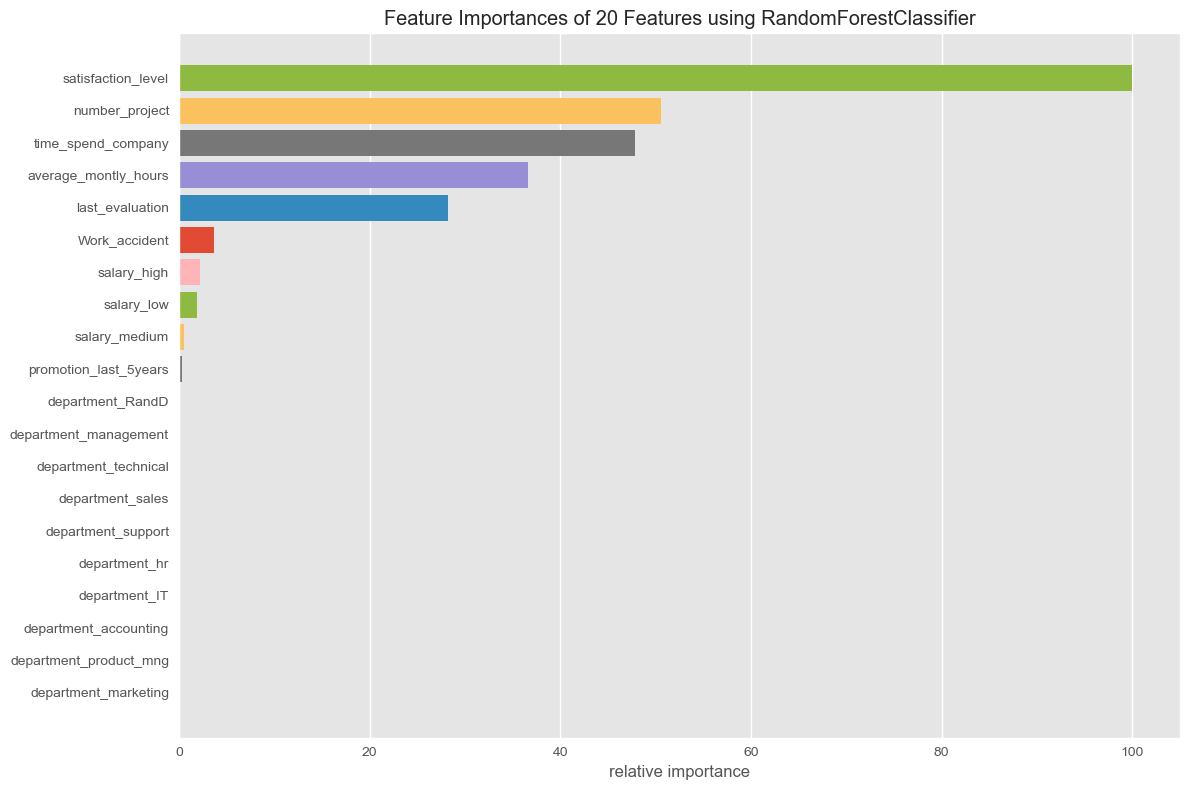

In [23]:
rf = RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=1, verbose=False)
viz = FeatureImportances(rf)
viz.fit(X_train,y_train)
viz.show();

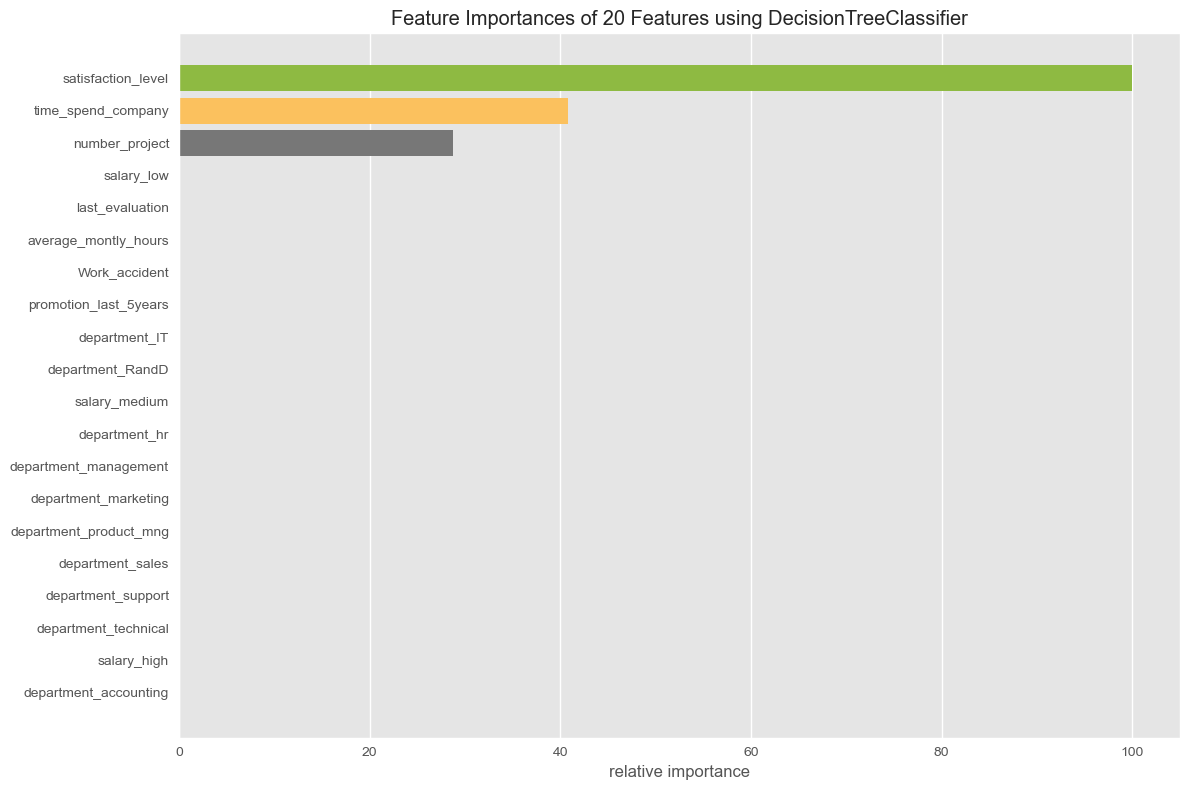

In [24]:
dt = DecisionTreeClassifier(max_depth=2, random_state=0)
viz = FeatureImportances(dt)
viz.fit(X_train,y_train)
viz.show();

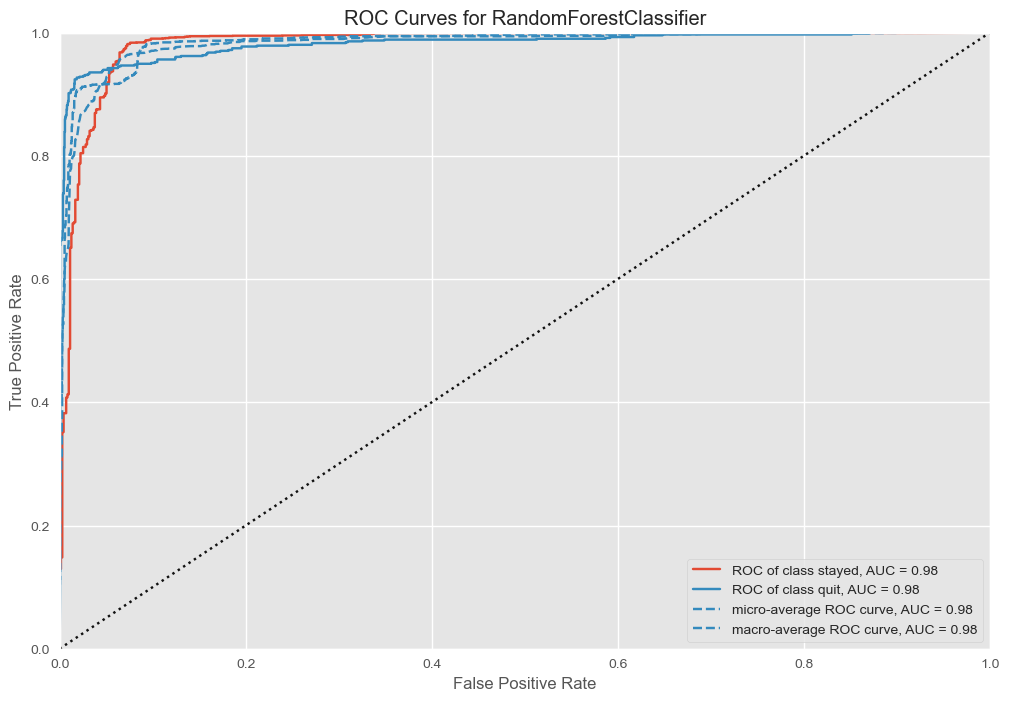

In [25]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(rf,classes=['stayed','quit'])
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.poof();


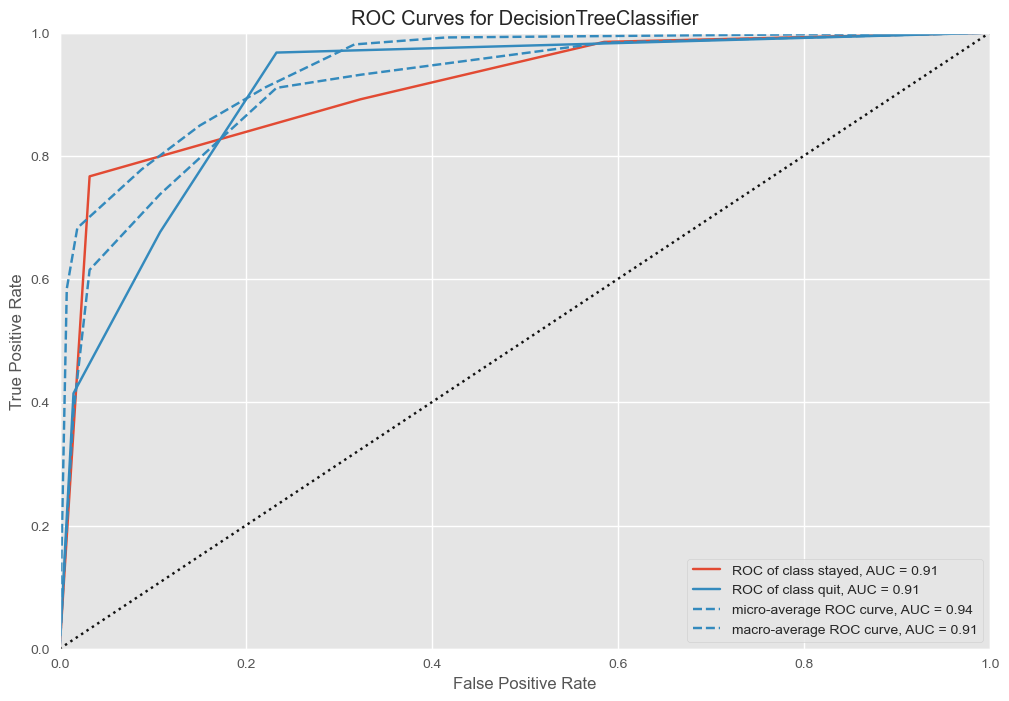

In [26]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(dt,classes=['stayed','quit'])
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.poof();

In [27]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
